# **Hidden Markov Models — Fundamentals, Inference & Learning**  
_Postgraduate-level, visual, and interactive tutorial._

**Goals of this notebook**
- Build intuition for HMMs using formulae and diagrams.
- Implement core inference algorithms from first principles: Forward-Backward, Viterbi, Baum–Welch (EM).
- Apply Gaussian-emission HMM to synthetic financial-return-like time series.
- Visualize posterior state probabilities, decoded paths, and EM learning with interactive sliders (ipywidgets).
- Explain each block of code and tie the mathematics to implementation details.

Prerequisites: probability at measure-theory friendly level (or comfort with conditional probability), basic linear algebra, Python (numpy, matplotlib), and Jupyter experience.

## What is an HMM? (Intuition)

A Hidden Markov Model (HMM) is a doubly stochastic process:

- There is a latent discrete-time Markov chain $ S_1, \dots, S_T $ taking values in a finite set of states $ \{1,\dots,K\} $.
- Observations $ O_1, \dots, O_T $ are conditionally independent given the latent states; each observation $ O_t $ is drawn from an emission distribution parameterized by the current state $ S_t $ .

Key probabilities:
- Initial state distribution: $ \pi_i = P(S_1 = i) $.
- Transition matrix: $ A_{ij} = P(S_{t+1}=j \mid S_t=i) $.
- Emission densities: $ b_j(o) = p(O_t=o \mid S_t=j) $.

Joint probability of an observed sequence $ o_{1:T} $ and state sequence $ s_{1:T} $:
$$
P(o_{1:T}, s_{1:T}) = \pi_{s_1} b_{s_1}(o_1)\prod_{t=2}^T A_{s_{t-1},s_t} b_{s_t}(o_t).
$$

We will work with continuous observations (Gaussian emissions) which is a common choice for financial returns modelling.

## Core inference & learning tasks

1. **Filtering / Smoothing**  
   - Filtering: $ P(S_t \mid o_{1:t}) $.  
   - Smoothing: $ P(S_t \mid o_{1:T}) $ (we will compute these via Forward-Backward).

2. **Decoding**  
   - Find the most likely hidden state sequence: $ \arg\max_{s_{1:T}} P(s_{1:T} \mid o_{1:T}) $ — solved by the Viterbi algorithm.

3. **Learning (Parameter Estimation)**  
   - Given only observations, estimate $ \theta = (\pi, A, \text{emission params}) $ — Baum–Welch algorithm (EM for HMMs).

Important formulae:

Forward variables (alpha):
$$
\alpha_1(i) = \pi_i b_i(o_1),\qquad
\alpha_t(j) = \sum_{i=1}^K \alpha_{t-1}(i) A_{ij} b_j(o_t).
$$

Backward variables (beta):
$$
\beta_T(i) = 1,\qquad
\beta_t(i) = \sum_{j=1}^K A_{ij} b_j(o_{t+1}) \beta_{t+1}(j).
$$

Posterior marginal (smoothing):
$$
\gamma_t(i) = P(S_t=i\mid o_{1:T}) = \frac{\alpha_t(i)\beta_t(i)}{\sum_{k=1}^K \alpha_t(k)\beta_t(k)}.
$$

Pairwise posterior (used in EM):
$$
\xi_t(i,j) = P(S_t=i,S_{t+1}=j\mid o_{1:T}) = \frac{\alpha_t(i) A_{ij} b_j(o_{t+1}) \beta_{t+1}(j)}{\sum_{p,q}\alpha_t(p) A_{pq} b_q(o_{t+1}) \beta_{t+1}(q)}.
$$

Log-likelihood can be computed stably by scaling or using log-sum-exp. We will implement the scaled forward-backward to avoid underflow.

### Imports and Setting Up the Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.stats import norm
from ipywidgets import interact, IntSlider, FloatSlider, fixed, Dropdown, Checkbox
import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True, precision=4)

## Numerical stability: scaling the forward-backward pass

Direct recursion for alpha (and beta) quickly underflows for long sequences because we multiply many probabilities.  
We adopt *scaling factors* $ c_t $ so that the scaled alphas sum to 1 (or some stable range) at each step.

Scaled forward:
$$
\hat\alpha_1(i) = \frac{\alpha_1(i)}{c_1},\qquad
c_1 = \sum_i \alpha_1(i)
$$
$$
\hat\alpha_t(j) = \frac{1}{c_t}\sum_i \hat\alpha_{t-1}(i) A_{ij} b_j(o_t),\qquad
c_t = \sum_j \sum_i \hat\alpha_{t-1}(i) A_{ij} b_j(o_t)
$$

With these scalings, the log-likelihood is:
$$
\log P(o_{1:T}) = \sum_{t=1}^T \log c_t.
$$

Backward recursion must be adapted to the same scaling:
$$
\hat\beta_T(i) = 1,\qquad
\hat\beta_t(i) = \sum_j A_{ij} b_j(o_{t+1}) \hat\beta_{t+1}(j) / c_{t+1}.
$$

Using scaled quantities we can compute gamma and xi stably.

## Scaled forward-backward implementation

In [2]:
def gaussian_pdf(x, mean, var):
    return norm.pdf(x, loc=mean, scale=np.sqrt(var))

def forward_backward_scaled(obs, pi, A, means, vars):
    T = len(obs)
    K = len(pi)
    alpha = np.zeros((T, K))
    beta = np.zeros((T, K))
    c = np.zeros(T)
    # t=0 (first time index)
    B0 = np.array([gaussian_pdf(obs[0], means[k], vars[k]) for k in range(K)])
    alpha[0] = pi * B0
    c[0] = alpha[0].sum()
    if c[0] == 0:
        c[0] = 1e-300
    alpha[0] = alpha[0] / c[0]
    # forward pass
    for t in range(1, T):
        B = np.array([gaussian_pdf(obs[t], means[k], vars[k]) for k in range(K)])
        alpha[t] = (alpha[t-1] @ A) * B
        c[t] = alpha[t].sum()
        if c[t] == 0:
            c[t] = 1e-300
        alpha[t] = alpha[t] / c[t]
    # backward pass (scaled)
    beta[-1] = np.ones(K)
    for t in range(T-2, -1, -1):
        B_next = np.array([gaussian_pdf(obs[t+1], means[k], vars[k]) for k in range(K)])
        beta[t] = (A * (B_next * beta[t+1])).sum(axis=1) / c[t+1]
    # compute gammas
    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)
    # compute xi
    xi = np.zeros((T-1, K, K))
    for t in range(T-1):
        B_next = np.array([gaussian_pdf(obs[t+1], means[k], vars[k]) for k in range(K)])
        denom = (alpha[t][:,None] * A * (B_next * beta[t+1])[None,:]).sum()
        if denom == 0:
            denom = 1e-300
        xi[t] = (alpha[t][:,None] * A * (B_next * beta[t+1])[None,:]) / denom
    loglik = np.sum(np.log(c + 1e-300))
    return alpha, beta, gamma, xi, loglik, c

## Viterbi algorithm

### Viterbi decoding — most probable state sequence

We want $ s^* = argmax_{s_{1:T}} P(s_{1:T} | o_{1:T}) $.  

This can be computed with dynamic programming:

Define $ \delta_t(j) = \max_{s_{1:t-1}} P(s_{1:t-1}, S_t=j, o_{1:t}) $.

Recurrence:
$$
\delta_1(i) = \pi_i b_i(o_1)
$$
$$
\delta_t(j) = b_j(o_t) \max_i \left(\delta_{t-1}(i) A_{ij} \right)
$$

We also store backpointers to recover the argmax sequence.

We implement a numerically stable version using logs to avoid underflow.

## Viterbi implementation

In [3]:
def viterbi(obs, pi, A, means, vars):
    T = len(obs)
    K = len(pi)
    logpi = np.log(pi + 1e-300)
    logA = np.log(A + 1e-300)
    logdelta = np.zeros((T, K))
    psi = np.zeros((T, K), dtype=int)
    # t=0
    logB0 = np.array([norm.logpdf(obs[0], loc=means[k], scale=np.sqrt(vars[k])) for k in range(K)])
    logdelta[0] = logpi + logB0
    for t in range(1, T):
        logBt = np.array([norm.logpdf(obs[t], loc=means[k], scale=np.sqrt(vars[k])) for k in range(K)])
        for j in range(K):
            seq_scores = logdelta[t-1] + logA[:, j]
            psi[t, j] = np.argmax(seq_scores)
            logdelta[t, j] = seq_scores[psi[t, j]] + logBt[j]
    # backtrack
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(logdelta[-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    best_logprob = np.max(logdelta[-1])
    return states, best_logprob

## Baum–Welch (EM) for Gaussian HMMs

We perform an Expectation-Maximization loop:

E-step: compute $ \gamma_t(i) $ and $ \xi_t(i,j) $ using current parameters.

M-step: update parameters to maximize expected complete-data log-likelihood:

- Initial distribution:
  $$
  \pi_i^{\text{new}} = \gamma_1(i)
  $$
- Transition matrix:
  $$
  A_{ij}^{\text{new}} = \frac{\sum_{t=1}^{T-1} \xi_t(i,j)}{\sum_{t=1}^{T-1} \gamma_t(i)}
  $$
- Gaussian emissions:
  $$
  \mu_i^{\text{new}} = \frac{\sum_{t=1}^T \gamma_t(i) o_t}{\sum_{t=1}^T \gamma_t(i)},\qquad
  \sigma_i^{2,\text{new}} = \frac{\sum_{t=1}^T \gamma_t(i) (o_t - \mu_i^{\text{new}})^2}{\sum_{t=1}^T \gamma_t(i)}
  $$

The algorithm converges to a local optimum of the observed-data likelihood. Initialization matters.

## Baum-Welch implementation

In [4]:
def baum_welch(obs, K, pi_init=None, A_init=None, means_init=None, vars_init=None,
               max_iter=100, tol=1e-6, verbose=False):
    T = len(obs)
    # initialize
    if pi_init is None:
        pi = np.ones(K) / K
    else:
        pi = pi_init.copy()
    if A_init is None:
        A = np.ones((K, K)) / K
    else:
        A = A_init.copy()
    if means_init is None:
        means = np.random.normal(loc=np.mean(obs), scale=np.std(obs), size=K)
    else:
        means = means_init.copy()
    if vars_init is None:
        vars_ = np.ones(K) * np.var(obs)
    else:
        vars_ = vars_init.copy()
    loglik_trace = []
    for it in range(max_iter):
        alpha, beta, gamma, xi, loglik, c = forward_backward_scaled(obs, pi, A, means, vars_)
        loglik_trace.append(loglik)
        # M-step
        pi_new = gamma[0].copy()
        A_new = xi.sum(axis=0) / (gamma[:-1].sum(axis=0)[:, None] + 1e-300)
        means_new = (gamma * obs[:, None]).sum(axis=0) / (gamma.sum(axis=0) + 1e-300)
        vars_new = ((gamma * (obs[:, None] - means_new[None, :])**2).sum(axis=0) /
                    (gamma.sum(axis=0) + 1e-300))
        # small floor for variances
        vars_new = np.maximum(vars_new, 1e-6)
        # check convergence (relative change in loglik)
        if it > 0 and abs(loglik_trace[-1] - loglik_trace[-2]) < tol:
            if verbose:
                print(f"Converged at iter {it}, loglik {loglik:.6f}")
            pi, A, means, vars_ = pi_new, A_new, means_new, vars_new
            break
        pi, A, means, vars_ = pi_new, A_new, means_new, vars_new
    return {"pi": pi, "A": A, "means": means, "vars": vars_, "loglik_trace": np.array(loglik_trace)}

## Synthetic data: regime-switching Gaussian returns

We simulate a simple 2- or 3-state HMM representing financial regimes:
- State 0: low-volatility, small positive drift
- State 1: high-volatility, zero or negative drift
- State 2 (optional): extreme events / heavy tails approximated by large variance Gaussian

Simulation steps:
- simulate discrete Markov chain with transition matrix A and initial distribution pi
- sample observations from Gaussians according to current state

This synthetic data provides a controlled environment to test inference, decoding, and learning.

## Simulate HMM Data

In [5]:
def simulate_hmm(T, pi, A, means, vars, random_state=None):
    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random
    K = len(pi)
    states = np.zeros(T, dtype=int)
    obs = np.zeros(T)
    states[0] = rng.choice(K, p=pi)
    obs[0] = rng.normal(loc=means[states[0]], scale=np.sqrt(vars[states[0]]))
    for t in range(1, T):
        states[t] = rng.choice(K, p=A[states[t-1]])
        obs[t] = rng.normal(loc=means[states[t]], scale=np.sqrt(vars[states[t]]))
    return obs, states

In [6]:
# Example 2-state system
K = 2
pi_truth = np.array([0.8, 0.2])
A_truth = np.array([[0.95, 0.05],
                    [0.10, 0.90]])
means_truth = np.array([0.001, -0.002])  # small drifts
vars_truth = np.array([1e-4, 5e-4])      # low vs high volatility (variance)
T = 500
obs, states_true = simulate_hmm(T, pi_truth, A_truth, means_truth, vars_truth, random_state=42)

## Visualize the simulated returns and true regimes

We will plot the observation time series and overlay the true hidden states (as colored background).
This helps connect the latent regimes to observable patterns (volatility clustering, drift changes).

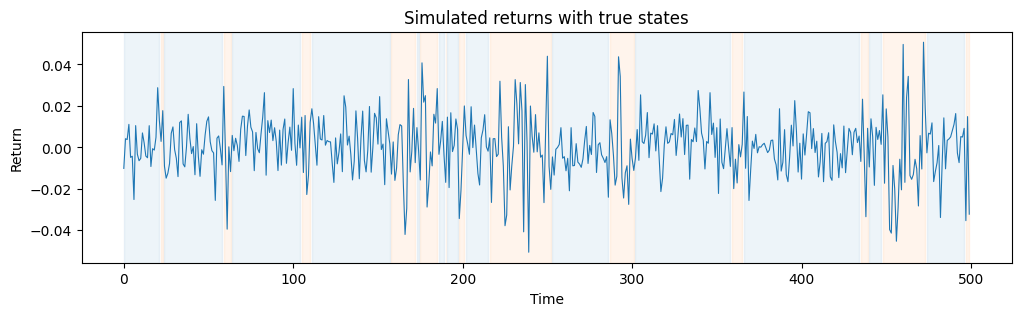

In [7]:
def plot_series_with_states(obs, states, title="Simulated returns with true states"):
    T = len(obs)
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax.plot(obs, lw=0.8)
    # colored background for states
    unique_states = np.unique(states)
    cmap = plt.get_cmap("tab10")
    for s in unique_states:
        mask = (states == s)
        # find contiguous segments for state s
        idx = np.where(mask)[0]
        if len(idx) == 0:
            continue
        segments = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
        for seg in segments:
            ax.axvspan(seg[0], seg[-1], color=cmap(s), alpha=0.08)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Return")
    plt.show()

plot_series_with_states(obs, states_true)

## Inference with true parameters (sanity check)

Compute smoothed posterior probabilities $ \gamma_t(i) $ using the true parameters.
Plot the posterior probability of each state over time and compare to the true states.

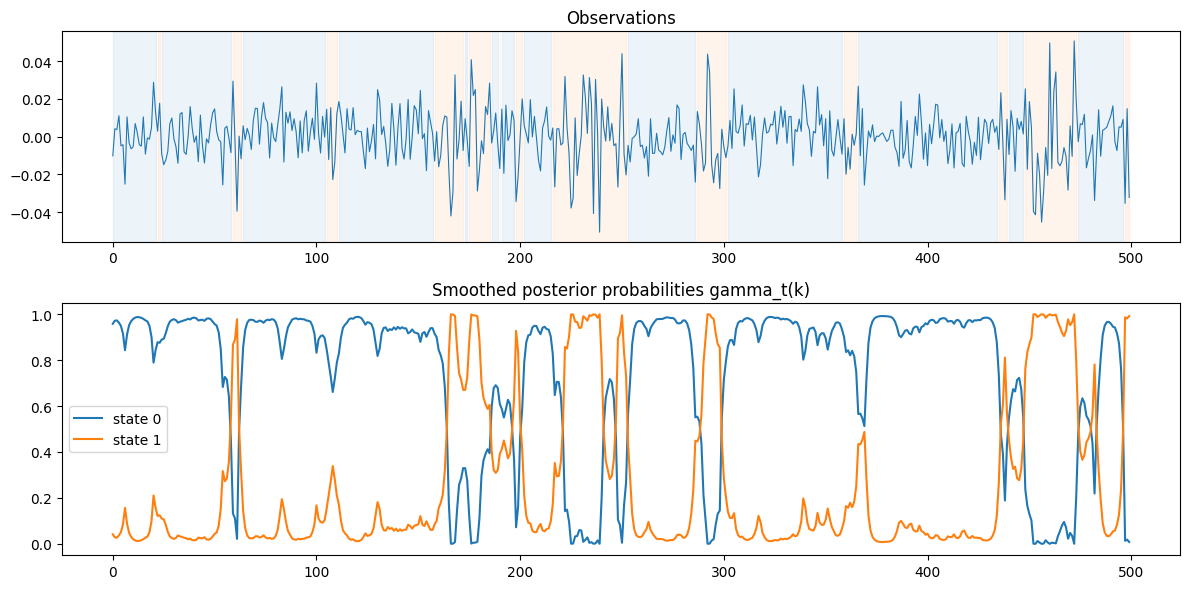

In [8]:
alpha, beta, gamma, xi, loglik, c = forward_backward_scaled(obs, pi_truth, A_truth, means_truth, vars_truth)

def plot_posteriors(obs, gamma, states_true=None):
    T, K = gamma.shape
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(2,1, height_ratios=[1,1.2])
    ax0 = plt.subplot(gs[0])
    ax0.plot(obs, lw=0.8)
    ax0.set_title("Observations")
    if states_true is not None:
        for s in np.unique(states_true):
            mask = (states_true == s)
            idx = np.where(mask)[0]
            if len(idx) == 0:
                continue
            segments = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
            for seg in segments:
                ax0.axvspan(seg[0], seg[-1], color=plt.get_cmap("tab10")(s), alpha=0.08)
    ax1 = plt.subplot(gs[1], sharex=ax0)
    for k in range(gamma.shape[1]):
        ax1.plot(gamma[:, k], label=f"state {k}")
    ax1.set_ylim(-0.05, 1.05)
    ax1.set_title("Smoothed posterior probabilities gamma_t(k)")
    ax1.legend()
    plt.tight_layout()
    plt.show()

plot_posteriors(obs, gamma, states_true)

## Visualize the simulated returns and true regimes

We will plot the observation time series and overlay the true hidden states (as colored background).
This helps connect the latent regimes to observable patterns (volatility clustering, drift changes).

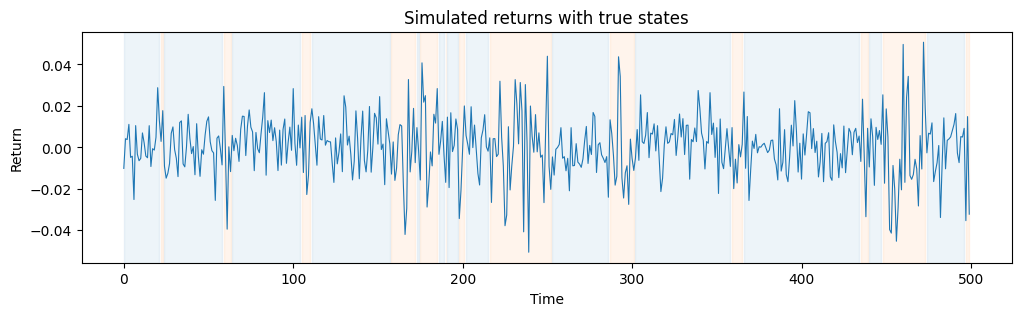

In [9]:
def plot_series_with_states(obs, states, title="Simulated returns with true states"):
    T = len(obs)
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    ax.plot(obs, lw=0.8)
    # colored background for states
    unique_states = np.unique(states)
    cmap = plt.get_cmap("tab10")
    for s in unique_states:
        mask = (states == s)
        # find contiguous segments for state s
        idx = np.where(mask)[0]
        if len(idx) == 0:
            continue
        segments = np.split(idx, np.where(np.diff(idx) != 1)[0]+1)
        for seg in segments:
            ax.axvspan(seg[0], seg[-1], color=cmap(s), alpha=0.08)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Return")
    plt.show()

plot_series_with_states(obs, states_true)

## Learning from observations: Baum–Welch (EM)

We now initialize parameters poorly and run Baum–Welch to recover model parameters.
We will visualize:
- log-likelihood trace over iterations
- learned means and variances vs ground truth
- posterior probabilities after learning

We will also provide interactive controls to change initialization or number of hidden states.

In [10]:
# Random init
np.random.seed(1)
K_try = 2
pi_init = np.array([0.5, 0.5])
A_init = np.array([[0.9, 0.1],[0.1, 0.9]])
means_init = np.array([0.0, 0.0]) + np.random.normal(scale=0.01, size=K_try)
vars_init = np.array([0.0001, 0.0005]) * (1 + 0.2 * np.random.rand(K_try))

res = baum_welch(obs, K_try, pi_init=pi_init, A_init=A_init, means_init=means_init, vars_init=vars_init,
                 max_iter=200, tol=1e-7, verbose=True)

print("Learned pi:", res["pi"])
print("Learned A:\n", res["A"])
print("Learned means:", res["means"])
print("Learned vars:", res["vars"])

Converged at iter 56, loglik 1441.286561
Learned pi: [1. 0.]
Learned A:
 [[0.9737 0.0263]
 [0.0813 0.9187]]
Learned means: [ 0.0012 -0.0022]
Learned vars: [0.0001 0.0005]


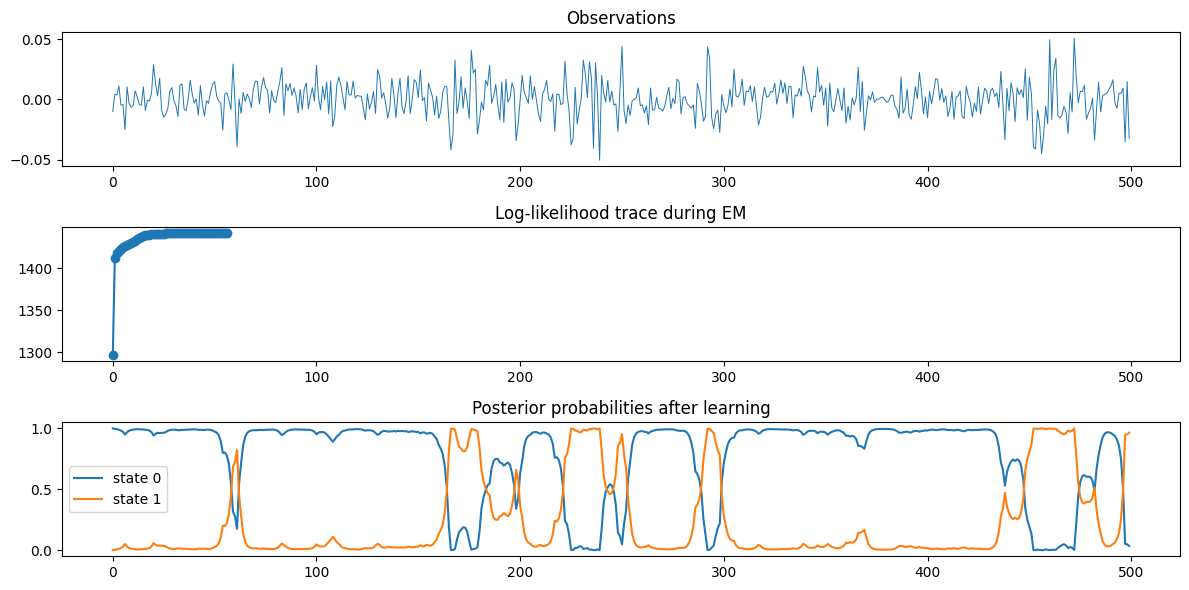

Ground truth means: [ 0.001 -0.002]
Learned means: [ 0.0012 -0.0022]
Ground truth vars: [0.0001 0.0005]
Learned vars: [0.0001 0.0005]


In [11]:
learned = res
alpha_l, beta_l, gamma_l, xi_l, loglik_l, c_l = forward_backward_scaled(obs, learned["pi"], learned["A"], learned["means"], learned["vars"])

def plot_learning_results(obs, states_true, res, gamma_after, loglik_trace):
    fig = plt.figure(figsize=(12,6))
    gs = gridspec.GridSpec(3,1, height_ratios=[0.6,0.6,0.6])
    ax0 = plt.subplot(gs[0])
    ax0.plot(obs, lw=0.7)
    ax0.set_title("Observations")
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(loglik_trace, marker='o')
    ax1.set_title("Log-likelihood trace during EM")
    ax2 = plt.subplot(gs[2], sharex=ax0)
    for k in range(gamma_after.shape[1]):
        ax2.plot(gamma_after[:, k], label=f"state {k}")
    ax2.set_title("Posterior probabilities after learning")
    ax2.legend()
    plt.tight_layout()
    plt.show()

plot_learning_results(obs, states_true, learned, gamma_l, res["loglik_trace"])

print("Ground truth means:", means_truth)
print("Learned means:", learned["means"])
print("Ground truth vars:", vars_truth)
print("Learned vars:", learned["vars"])

## Interactive exploration with ipywidgets

The following interactive function allows:
- choice of number of states K (2 or 3)
- sequence length T (subset length for speed)
- random initialization seed
- run Baum–Welch and show:
  - loglikelihood trace
  - learned emission parameters
  - posterior probabilities overlay

This supports intuition about identifiability, local optima, and how well EM recovers regimes from data that may be short or noisy.

In [ ]:
def interactive_emplay(K=2, T_sub=300, seed=0, max_iter=200):
    # use prefix of obs
    obs_sub = obs[:T_sub]
    # initialize
    rng = np.random.RandomState(seed)
    pi_init = np.ones(K)/K
    A_init = rng.dirichlet([5]*K, size=K)
    # ensure row stochastic
    A_init = A_init / A_init.sum(axis=1, keepdims=True)
    # initial means: random around empirical mean
    means_init = np.mean(obs_sub) + rng.normal(scale=np.std(obs_sub), size=K)*0.1
    vars_init = np.ones(K) * np.var(obs_sub) * (0.5 + rng.rand(K))
    # run EM
    res = baum_welch(obs_sub, K, pi_init=pi_init, A_init=A_init, means_init=means_init, vars_init=vars_init,
                     max_iter=max_iter, tol=1e-7, verbose=False)
    # posterior under learned params
    alpha, beta, gamma, xi, loglik, c = forward_backward_scaled(obs_sub, res["pi"], res["A"], res["means"], res["vars"])
    # plots
    fig = plt.figure(figsize=(12,7))
    gs = gridspec.GridSpec(3,1, height_ratios=[0.6,0.6,1.0])
    ax0 = plt.subplot(gs[0])
    ax0.plot(obs_sub)
    ax0.set_title("Observations (subset)")
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(res["loglik_trace"], marker='o')
    ax1.set_title("Log-likelihood trace")
    ax2 = plt.subplot(gs[2], sharex=ax0)
    for k in range(K):
        ax2.plot(gamma[:,k], label=f"state {k} posterior")
    ax2.set_title("Posteriors after EM")
    ax2.legend()
    plt.tight_layout()
    plt.show()
    print("Learned means:", res["means"])
    print("Learned vars:", res["vars"])
    print("Learned A:\n", res["A"])
    print("Learned pi:", res["pi"])

interact(interactive_emplay,
         K=Dropdown(options=[2,3], value=2, description='K'),
         T_sub=IntSlider(min=100, max=min(1000, len(obs)), step=50, value=300, description='T'),
         seed=IntSlider(min=0, max=999, step=1, value=0, description='seed'),
        )

interactive(children=(Dropdown(description='K', options=(2, 3), value=2), IntSlider(value=300, description='T'…

<function __main__.interactive_emplay(K=2, T_sub=300, seed=0, max_iter=200)>

## Discussion, limitations & next steps

**Key observations**
- Scaling is essential for numerical stability (we used per-time scaling factors).
- EM finds local maxima — initialization (and model order K) matter.
- HMM with Gaussian emissions is a useful and interpretable model for regime-switching returns, but heavy tails in finance might require Student-t emissions or mixture-of-Gaussians.
- Viterbi gives a single hard segmentation; smoothing provides uncertainty quantification for each time step.

**Next-level enhancements**
- Hidden Semi-Markov Models (HSMM) to model state dwell-time distributions explicitly (not geometric).
- Bayesian HMM (variational or MCMC) to quantify posterior uncertainty in parameters.
- HMM + RNN/Transformer hybrids: let deep models supply flexible emission likelihoods while retaining interpretable discrete regimes.
- Graph-HMMs for modeling interactions across multiple accounts / instruments (relevant for fund-trail analytics).

**Practical notes**
- For real financial data: preprocess returns, remove microstructure noise, be mindful of non-stationarities.
- Use information criteria (BIC/AIC) and predictive checks when selecting K.

## References & Suggested Reading

- L. R. Rabiner, "A Tutorial on Hidden Markov Models and Selected Applications in Speech Recognition", Proceedings of the IEEE, 1989.
- Kevin P. Murphy, "Machine Learning: A Probabilistic Perspective", Chapter on HMMs.
- Shumway & Stoffer, "Time Series Analysis and Its Applications", for state-space and switching models.
- Research: regime-switching models in finance (Hamilton, Markov-switching models), Bayesian HMM literature, HSMM references.